<a href="https://colab.research.google.com/github/mubarak-hm/resnet-150/blob/main/Resnet_150_brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil
import random
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
import math
import shutil
import torch
import random
from torch.optim.optimizer import Optimizer, required
import pathlib
from zipfile import ZipFile

In [ ]:

# Define paths
zip_path = '/content/drive/MyDrive/NINS_Dataset.zip'  # Adjust path if needed
extract_path = '/content/drive/MyDrive/NINS_Dataset'  # Extracted dataset location

#Extract the zip file if not already extracted
if not os.path.exists(extract_path):
   with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
   print("Dataset extracted successfully!")

# Update base_dir to the extracted dataset location
base_dir = '/content/NINS_Dataset'  # Adjust if the dataset extracts into another subfolder

# Get all class names (subdirectories)
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Paths to training and validation directories
working_dir = '/content/working'
train_dir = os.path.join(working_dir, 'train')
val_dir = os.path.join(working_dir, 'val')

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Train-validation split ratio
split_ratio = 0.8  # 80% train, 20% validation

# Organize dataset into train and validation folders
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)  # Each class is a subdirectory

    # Get only image files inside the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Shuffle images randomly
    random.shuffle(images)

    # Compute split index
    split_idx = int(len(images) * split_ratio)

    # Split into train and validation sets
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Define class folders in train and val directories
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    # Create class folders if they don't exist
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    # Copy train images
    for img in train_images:
        shutil.copy2(os.path.join(class_dir, img), os.path.join(train_class_dir, img))

    # Copy validation images
    for img in val_images:
        shutil.copy2(os.path.join(class_dir, img), os.path.join(val_class_dir, img))

    print(f"Processed {class_name}: {len(train_images)} train, {len(val_images)} validation")

print(f"✅ Train directory: {train_dir}")
print(f"✅ Validation directory: {val_dir}")




Dataset extracted successfully!
Processed Astrocitoma: 464 train, 116 validation
Processed Obstructiv_Hydrocephalus: 60 train, 16 validation
Processed Stroke- Demyelination: 30 train, 8 validation
Processed cerebral_venous_sinus_thrombosis: 60 train, 16 validation
Processed Stroke_Haemorrhage: 451 train, 113 validation
Processed Vestibular Schwannoma: 98 train, 25 validation
Processed pituitary: 1405 train, 352 validation
Processed craniopharyngioma: 30 train, 8 validation
Processed Stroke_infarct: 724 train, 182 validation
Processed glioma: 1296 train, 325 validation
Processed Papiloma: 189 train, 48 validation
Processed meningioma: 2180 train, 545 validation
Processed Granuloma: 62 train, 16 validation
Processed Small Vessel Diease_Demyelination: 30 train, 8 validation
Processed focal pachymeningitis: 28 train, 8 validation
Processed Ependymoma: 28 train, 8 validation
Processed Schwannoma: 372 train, 93 validation
Processed Encephalomalacia with gliotic change: 60 train, 16 validatio

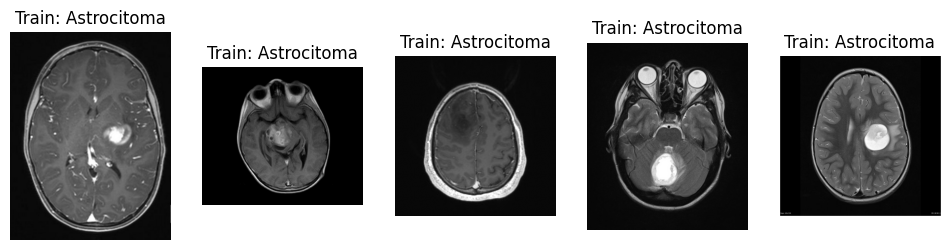

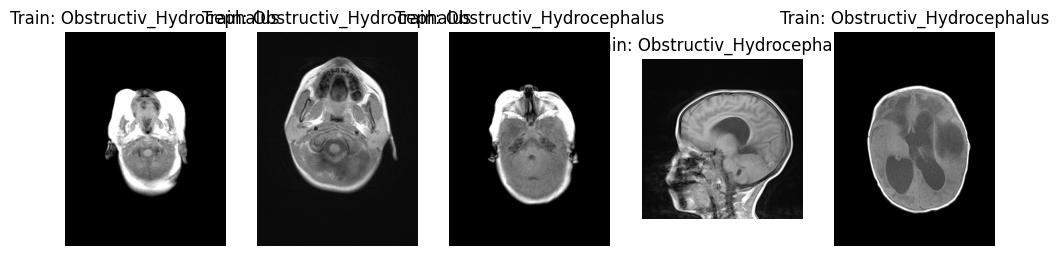

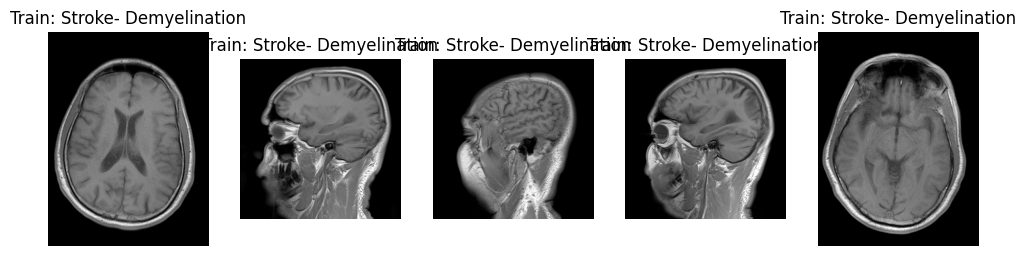

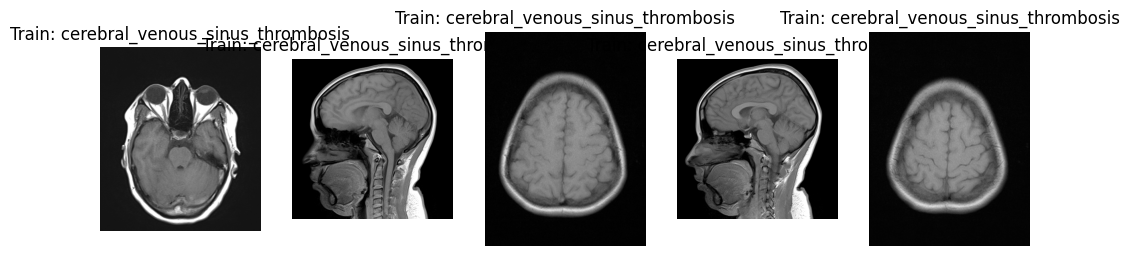

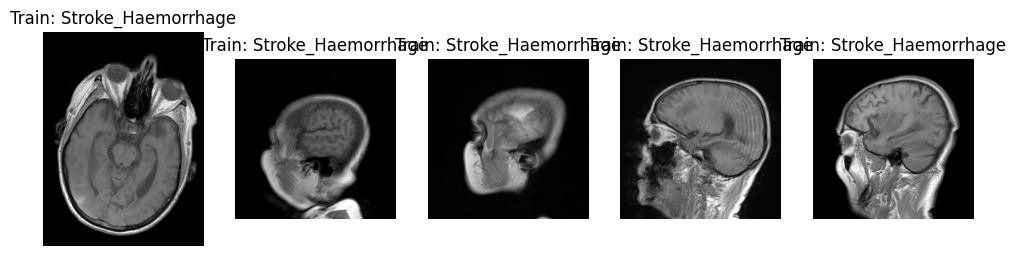

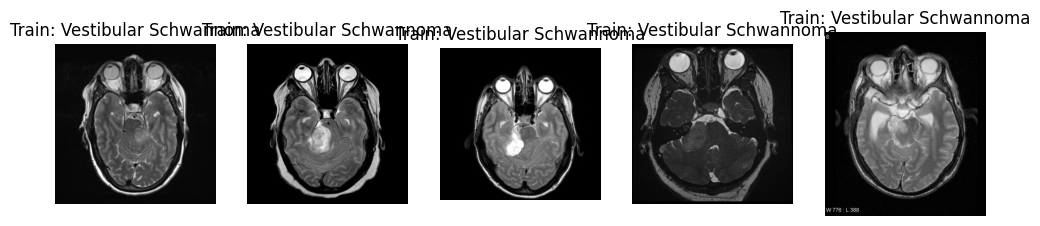

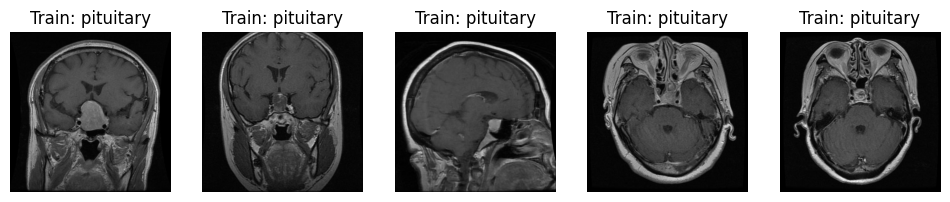

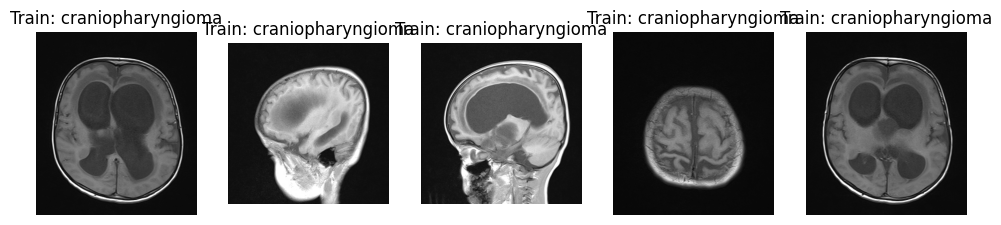

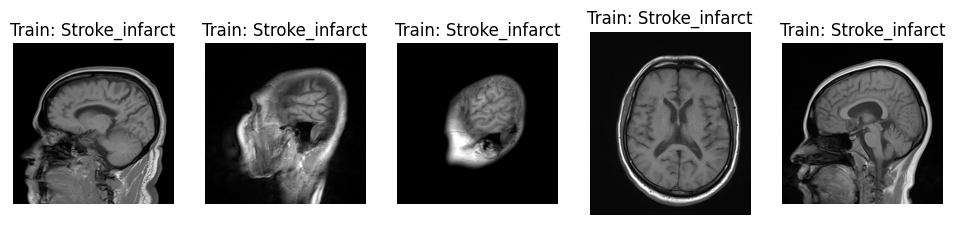

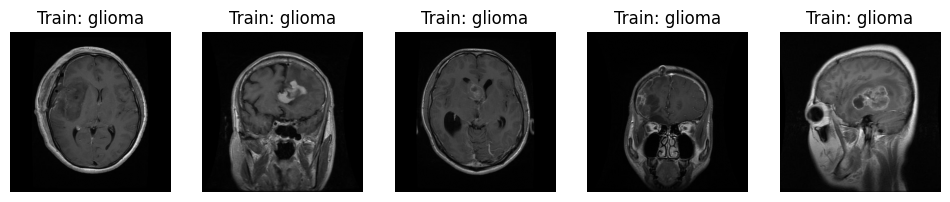

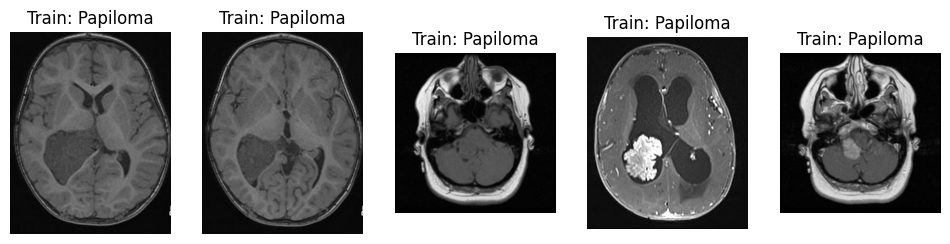

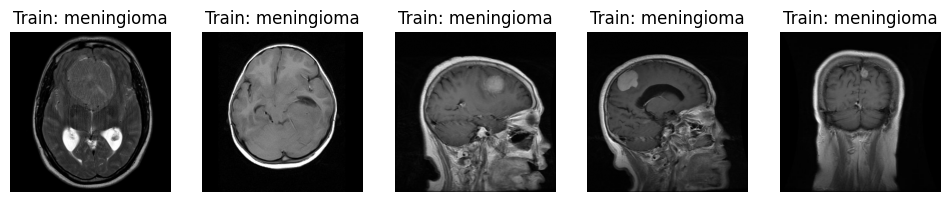

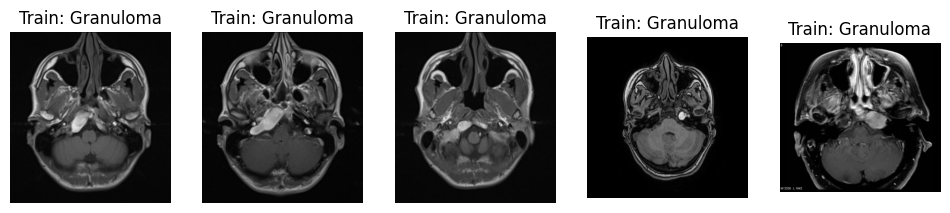

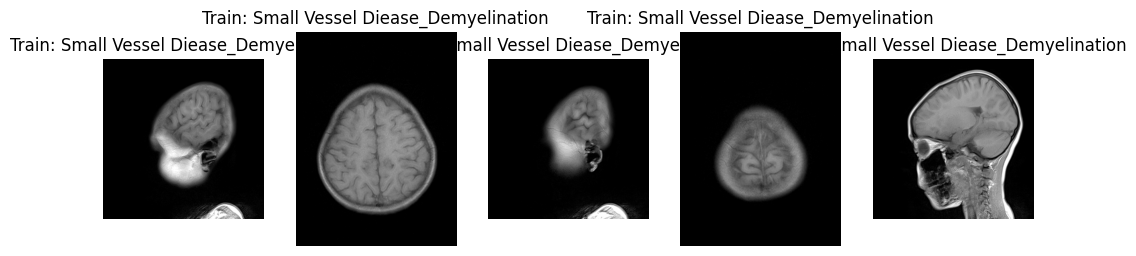

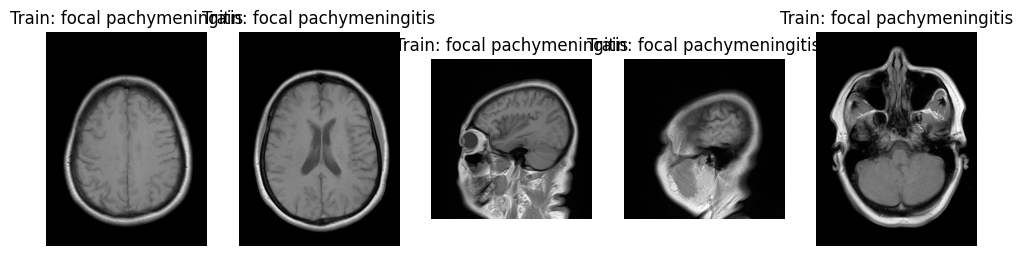

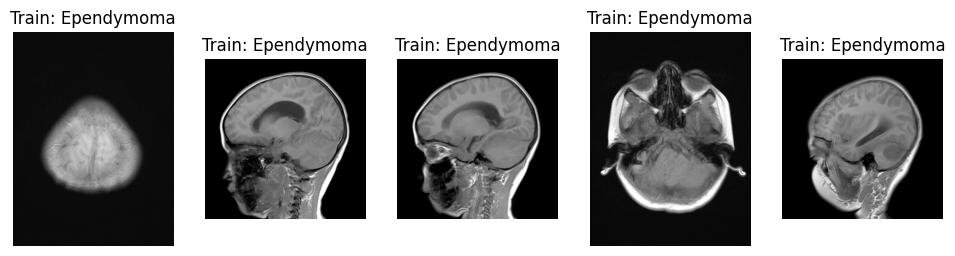

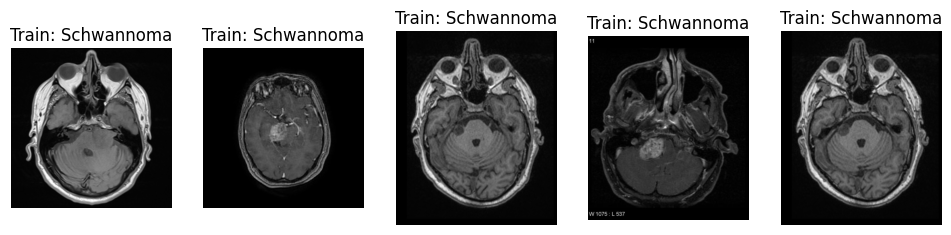

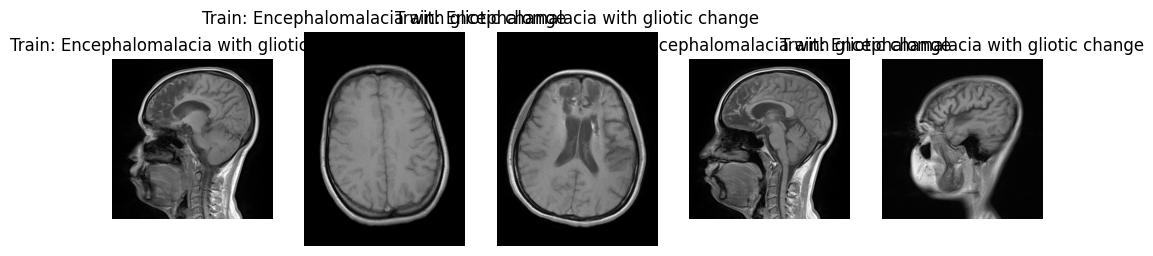

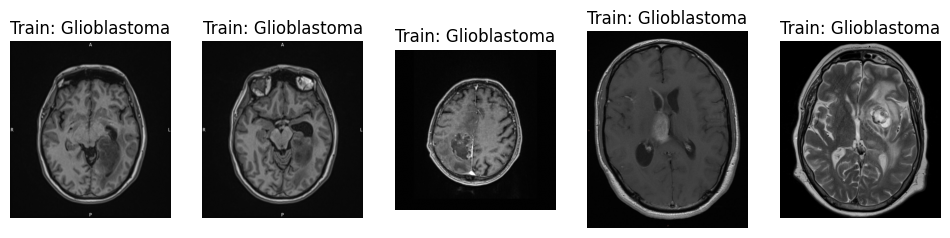

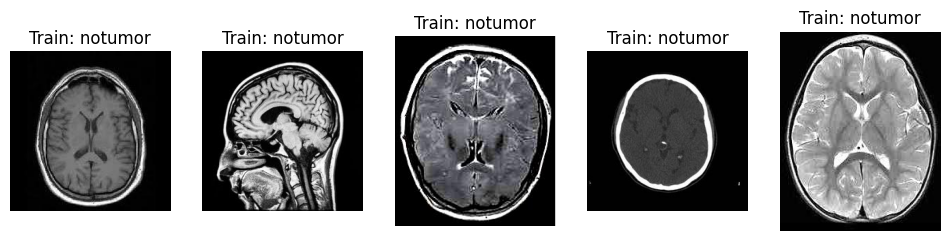

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def display_sample_images(base_class_dir, class_name, title, num_samples=5):
    """Displays sample images from a given class directory (train or validation)."""
    class_dir = os.path.join(base_class_dir, class_name)

    if not os.path.exists(class_dir):
        print(f"Directory {class_dir} does not exist.")
        return

    image_files = os.listdir(class_dir)

    if len(image_files) == 0:
        print(f"No images found in {class_dir}.")
        return

    # Randomly select images (or take fewer if less available)
    image_paths = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(12, 4))
    for i, image_file in enumerate(image_paths):
        img_path = os.path.join(class_dir, image_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.show()

# Display sample images from train dataset
for class_name in class_names:
    display_sample_images(train_dir, class_name, f'Train: {class_name}')

# Display sample images from validation dataset
for class_name in class_names:
    display_sample_images(val_dir, class_name, f'Validation: {class_name}')


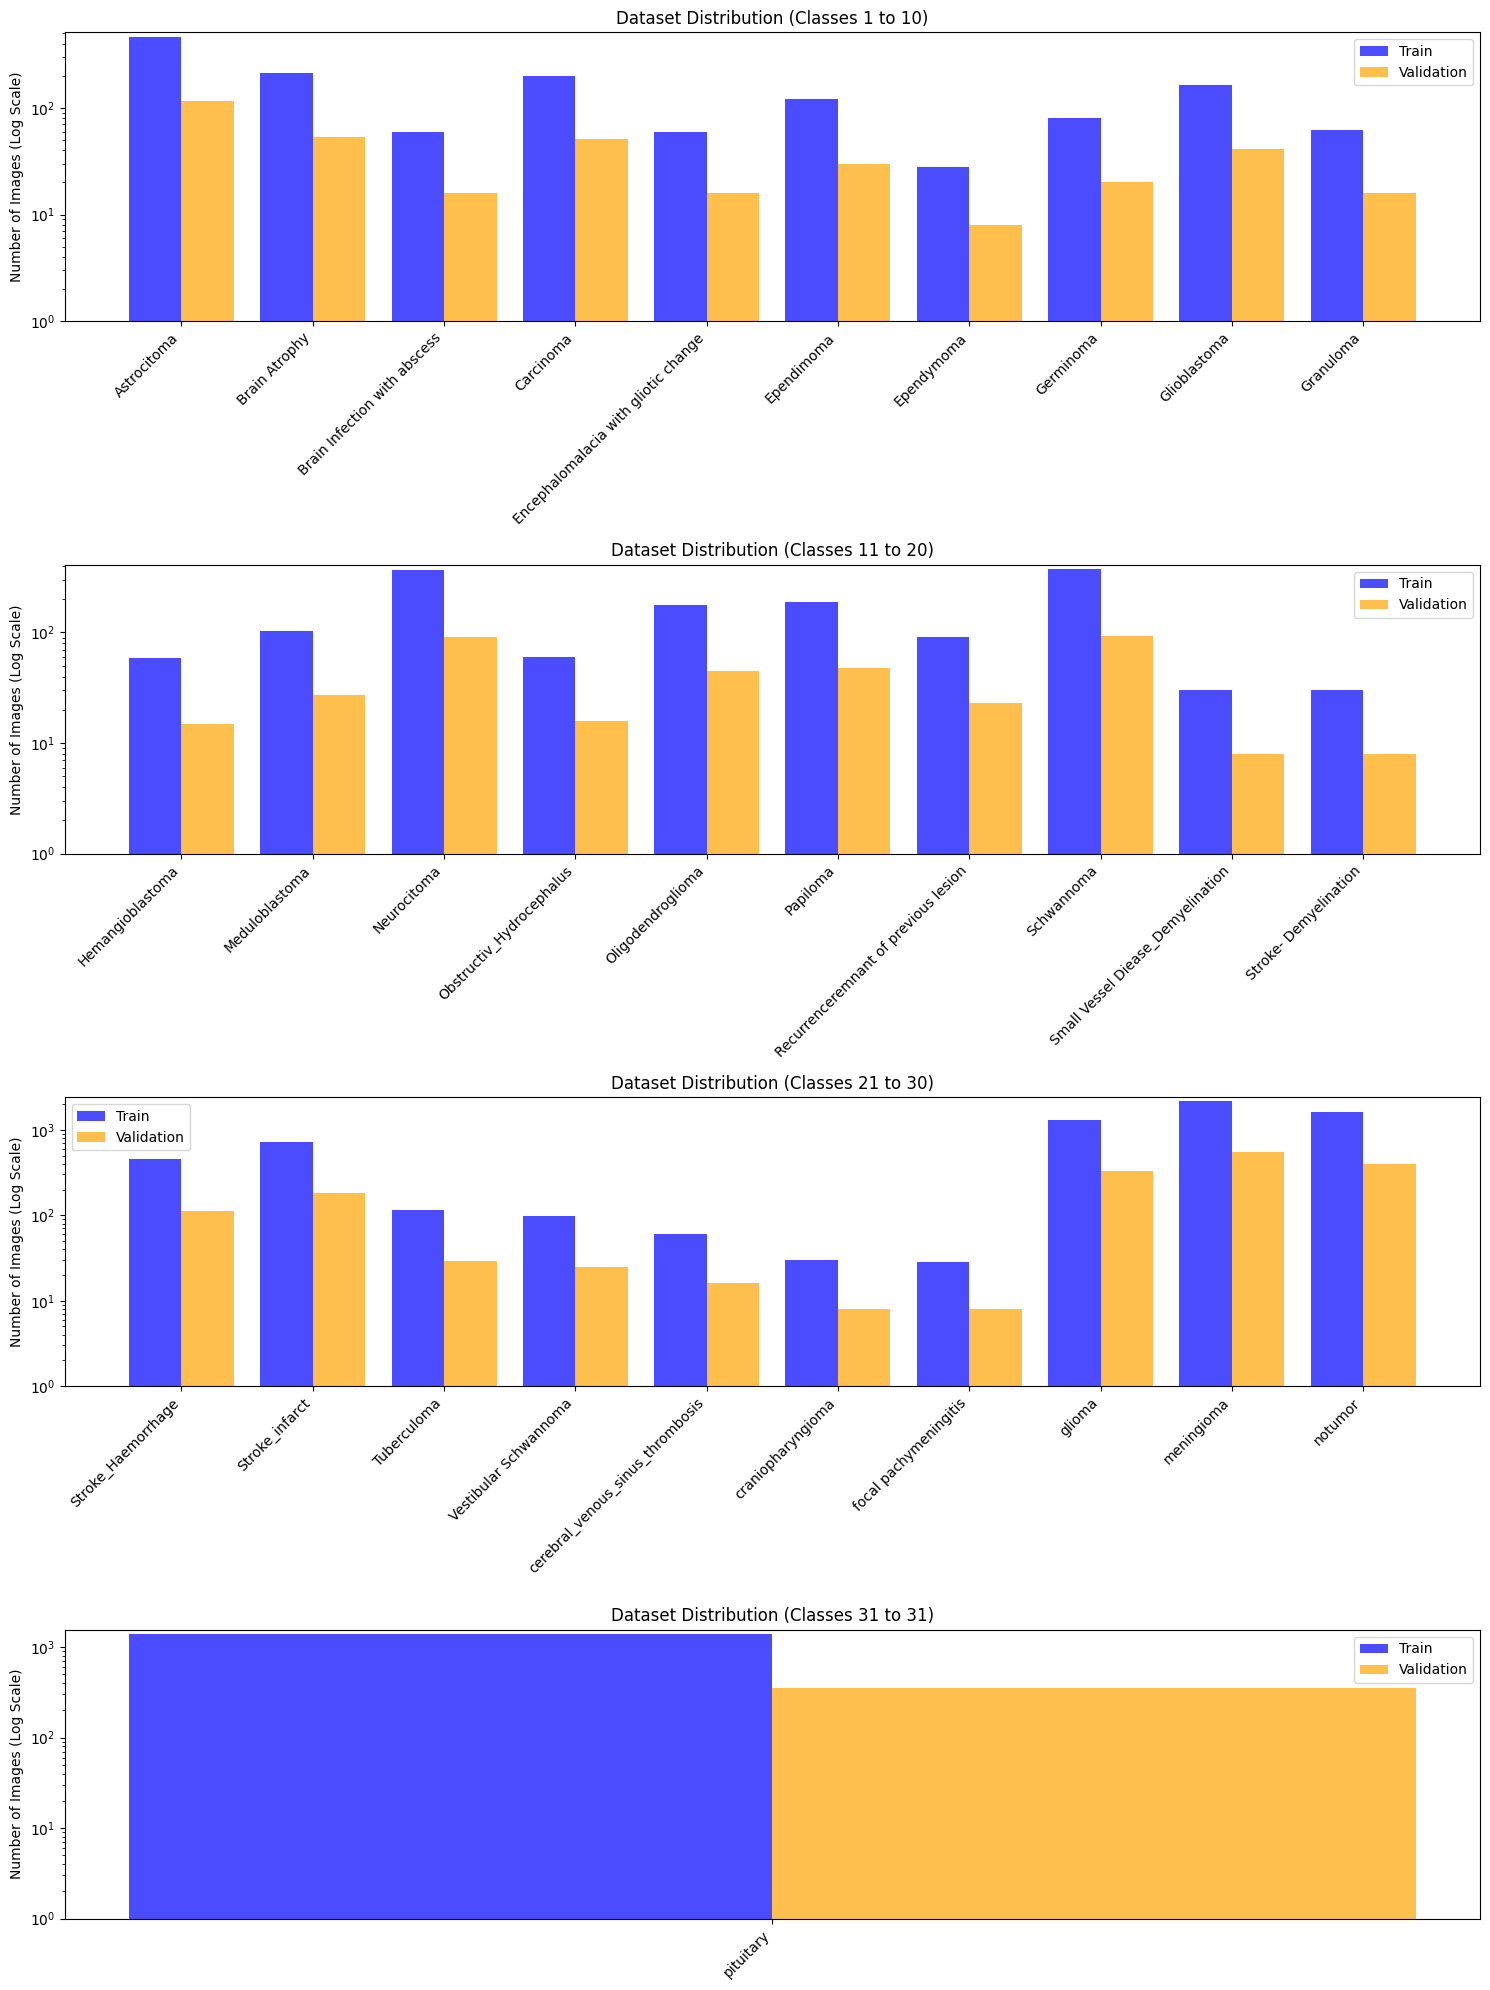

In [ ]:
import os
import matplotlib.pyplot as plt
import math

# Function to get image counts (unchanged)
def get_image_count(class_dir):
    """Returns the number of images in a given class directory."""
    if not os.path.exists(class_dir):
        return 0
    return len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

# Paths to train and validation directories
train_dir = '/content/working/train'
val_dir = '/content/working/val'

# Get class names
class_names = sorted(os.listdir(train_dir))

# Dictionary to store image counts
image_counts = {}
for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    train_count = get_image_count(train_class_dir)
    val_count = get_image_count(val_class_dir)

    image_counts[class_name] = {'train': train_count, 'val': val_count}

# Split classes into groups (e.g., 10 classes per subplot)
classes_per_subplot = 10
num_subplots = math.ceil(len(class_names) / classes_per_subplot)

# Create subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(15, 5 * num_subplots))
if num_subplots == 1:
    axes = [axes]  # Ensure axes is a list even for a single subplot

bar_width = 0.4
for i in range(num_subplots):
    start_idx = i * classes_per_subplot
    end_idx = min((i + 1) * classes_per_subplot, len(class_names))
    subplot_classes = class_names[start_idx:end_idx]

    train_counts = [image_counts[class_name]['train'] for class_name in subplot_classes]
    val_counts = [image_counts[class_name]['val'] for class_name in subplot_classes]

    x_indexes = range(len(subplot_classes))
    axes[i].bar(x_indexes, train_counts, width=bar_width, label='Train', alpha=0.7, color='blue')
    axes[i].bar([x + bar_width for x in x_indexes], val_counts, width=bar_width, label='Validation', alpha=0.7, color='orange')

    axes[i].set_xticks([x + bar_width / 2 for x in x_indexes])
    axes[i].set_xticklabels(subplot_classes, rotation=45, ha='right', fontsize=10)
    axes[i].set_ylabel('Number of Images (Log Scale)')
    axes[i].set_yscale('log')
    axes[i].set_ylim(1, max(train_counts + val_counts) * 1.1)
    axes[i].set_title(f'Dataset Distribution (Classes {start_idx+1} to {end_idx})', fontsize=12)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define image size and preprocessing transformations
IMG_SIZE = 224  # Standard for ResNet models
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_transforms)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 31


In [ ]:
# Load pre-trained ResNet152
model = models.resnet152(pretrained=True)

# Freeze base layers (optional, unfreeze later for fine-tuning if needed)
for param in model.parameters():
    param.requires_grad = True

# Replace the final fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model_path = '/content/drive/MyDrive/nins_resnet152_model.pth'
model.load_state_dict(torch.load(model_path))
print(f"Model loaded successfully from {model_path}")
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 163MB/s]


Model loaded successfully from /content/drive/MyDrive/nins_resnet152_model.pth


In [ ]:
def gradient_central(x, apply_centralization=True, centralize_conv_layers_only=False):
    constant_size = x.size()
    base = list(constant_size)
    # '''credit - https://github.com/Yonghongwei/Gradient-Centralization '''

    if apply_centralization:
        if centralize_conv_layers_only:
            if len(base) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(base))), keepdim=True))
        elif len(base) > 1:
            x.add_(-x.mean(dim=tuple(range(1, len(base))), keepdim=True))
    return x

class RangerOptimizer(Optimizer):
    def __init__(self, weights, learning_rate=1e-3, alpha=0.5, k=6, N_sma_threshhold=5,
                 betas=(0.95, 0.999), eps=1e-5, weight_decay=0,
                 apply_centralization=True, centralize_conv_layers_only=False, centralize_now=True):

        if not (0 <= alpha <= 1.0):
            raise ValueError(f'The provided slow update rate {alpha} is invalid')

        if k < 1:
            raise ValueError(f'Invalid value {k} for look ahead steps')

        if learning_rate < 0:
            raise ValueError(f'Invalid value {learning_rate} for learning rate')

        defaults = dict(learning_rate=learning_rate, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(weights, defaults)

        self.N_sma_threshhold = N_sma_threshhold
        self.alpha = alpha
        self.k = k
        self.radam_buffer = [[None, None, None] for _ in range(10)]
        self.apply_centralization = apply_centralization
        self.centralize_now = centralize_now
        self.centralize_conv_layers_only = centralize_conv_layers_only

        print(f"Ranger optimizer loaded. \nGradient centralization= {self.apply_centralization}")

        if self.apply_centralization and not self.centralize_conv_layers_only:
            print(f"GC applied to both conv and fc layers")
        elif self.apply_centralization and self.centralize_conv_layers_only:
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(RangerOptimizer, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError('Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                if self.centralize_now:
                    grad = gradient_central(grad, apply_centralization=self.apply_centralization,
                                            centralize_conv_layers_only=self.centralize_conv_layers_only)

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                              (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])

                if not self.centralize_now:
                    G_grad = gradient_central(G_grad, apply_centralization=self.apply_centralization,
                                              centralize_conv_layers_only=self.centralize_conv_layers_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['learning_rate'])
                p.data.copy_(p_data_fp32)

                if state['step'] % group['k'] == 0:
                    slow_p = state['slow_buffer']
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    p.data.copy_(slow_p)

        return loss





In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = RangerOptimizer(
    model.parameters(),
    learning_rate=1e-5,
    alpha=0.5,
    k=6,
    N_sma_threshhold=5,
    betas=(0.95, 0.999),
    eps=1e-5,
    weight_decay=0.01,
    apply_centralization=True,
    centralize_conv_layers_only=False,
    centralize_now=True
)

Ranger optimizer loaded. 
Gradient centralization= True
GC applied to both conv and fc layers


In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Training loop
NUM_EPOCHS = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for epoch in range(NUM_EPOCHS):
     print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Train Loss: 0.0759, Train Acc: 97.16%
Val Loss: 0.0264, Val Acc: 98.72%
Train Loss: 0.0759, Train Acc: 97.16%
Val Loss: 0.0264, Val Acc: 98.72%
Epoch 2/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Train Loss: 0.0711, Train Acc: 97.24%
Val Loss: 0.0295, Val Acc: 98.47%
Train Loss: 0.0711, Train Acc: 97.24%
Val Loss: 0.0295, Val Acc: 98.47%
Epoch 3/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Train Loss: 0.0717, Train Acc: 97.35%
Val Loss: 0.0268, Val Acc: 98.69%
Train Loss: 0.0717, Train Acc: 97.35%
Val Loss: 0.0268, Val Acc: 98.69%
Epoch 4/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Train Loss: 0.0689, Train Acc: 97.50%
Val Loss: 0.0294, Val Acc: 98.47%
Train Loss: 0.0689, Train Acc: 97.50%
Val Loss: 0.0294, Val Acc: 98.47%
Epoch 5/5
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
Train Loss: 0.0614, Train Acc: 97.71%
Val Loss: 0.0334, Val Acc: 98.29%
Train Loss: 0.0614, Train Acc: 97.71%
Val Loss: 0.03

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing (same as before)
IMG_SIZE = 224
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load validation dataset
val_dir = '/content/working/val'
val_dataset = ImageFolder(val_dir, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
num_classes = len(val_dataset.classes)
class_names = val_dataset.classes  # For labeling confusion matrix

# Load the trained model
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model_path = '/content/drive/MyDrive/nins_resnet152_model.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()
print(f"Model loaded from {model_path}")

# Function to evaluate and get predictions
def get_predictions(model, data_loader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, true_labels = get_predictions(model, val_loader, device)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, preds, labels=range(num_classes))
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Compute TP, FP, FN, TN for each class
tp = np.diag(conf_matrix)  # True Positives per class
fp = conf_matrix.sum(axis=0) - tp  # False Positives per class
fn = conf_matrix.sum(axis=1) - tp  # False Negatives per class
tn = conf_matrix.sum() - (fp + fn + tp)  # True Negatives per class

# Compute metrics per class using the paper's equations (adapted for multi-class)
accuracy_per_class = (tp + tn) / (tp + tn + fp + fn)  # Equation 03
precision_per_class = tp / (tp + fp)  # Equation 05
recall_per_class = tp / (tp + fn)  # Recall (not in paper, standard formula)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)

# Handle division by zero
precision_per_class = np.nan_to_num(precision_per_class)
recall_per_class = np.nan_to_num(recall_per_class)
f1_per_class = np.nan_to_num(f1_per_class)

# Average metrics across classes (macro average)
accuracy = np.mean(accuracy_per_class)
precision = np.mean(precision_per_class)
recall = np.mean(recall_per_class)
f1 = np.mean(f1_per_class)

# Print results
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Macro): {precision * 100:.2f}%")
print(f"Recall (Macro): {recall * 100:.2f}%")
print(f"F1-Score (Macro): {f1 * 100:.2f}%")

# Optional: Per-class metrics
for i, class_name in enumerate(class_names):
    print(f"\nClass: {class_name}")
    print(f"  Accuracy: {accuracy_per_class[i] * 100:.2f}%")
    print(f"  Precision: {precision_per_class[i] * 100:.2f}%")
    print(f"  Recall: {recall_per_class[i] * 100:.2f}%")
    print(f"  F1-Score: {f1_per_class[i] * 100:.2f}%")

# Plot normalized confusion matrix (like Figure 06 in the paper)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/working/val'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/nins_resnet152_model.pth')

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
}, '/content/drive/MyDrive/nins_checkpoint.pth')

# Training The Model


# Evaluating The Model